In [102]:
import numpy as np
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn import covariance
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
import networkx as nx
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

In [147]:
# Data from https://tradingstrategy.ai/trading-view/backtesting

resolution = '4h'
try:
    prices = pd.read_parquet('C:/Users/Walid/Desktop/Workspace/data/candles-{}.parquet'.format(resolution))
    pairs = pd.read_parquet('C:/Users/Walid/Desktop/Workspace/data/pair-universe.parquet')
    with open('C:/Users/Walid/Desktop/Workspace/data/exchange-universe.json', 'r') as f:
        exchange_json = json.load(f)
    exchanges = pd.DataFrame(exchange_json['exchanges']).T
except:
    print('Cannot find candles-{} data'.format(resolution))
    
# Filter universe
univ2_pairs = pairs.loc[(pairs['exchange_id'] == 1) & (pairs['sell_tax'] == 0.0) & (pairs['buy_count_30d'] > 1000) & (pairs['sell_count_30d'] > 1000)].sort_values(['buy_volume_30d'], ascending=False)
univ2_pairs['symbol'] = univ2_pairs.apply(lambda row: row.token0_symbol + row.token1_symbol, axis=1)
univ2_prices = prices[prices['pair_id'].isin(univ2_pairs['pair_id'].values)]
symbols_map = univ2_pairs[['pair_id', 'symbol']].set_index('pair_id').to_dict()['symbol']
univ2_prices['symbol'] = univ2_prices['pair_id'].map(symbols_map)

timestamps = univ2_prices['timestamp'].unique()
timestamps.sort()
univ2_close_price = pd.DataFrame(index=timestamps, columns=symbols_map.values())
for symbol in univ2_close_price.columns:
    univ2_close_price[symbol] = univ2_prices.loc[univ2_prices['symbol'] == symbol, ['timestamp', 'close']].set_index('timestamp')

minimum_date = datetime.fromisoformat('2021-05-01 00:00:00+00:00')
univ2_close_price = univ2_close_price[minimum_date:].T.dropna().T
univ2_close_price

,USDCWETH,WETHUSDT,UNIWETH,DAIWETH,ELONWETH,HEXWETH,USDCUSDT,SHIBWETH,SANDWETH,LINKWETH,MATICWETH
2021-05-01 00:00:00,2833.710205,2835.195557,41.079014,2828.695801,2.614609e-07,0.017028,1.001549,0.000002,0.618121,38.629997,0.822371
2021-05-01 04:00:00,2844.345703,2857.502197,40.730049,2862.121826,2.464889e-07,0.017032,0.996876,0.000002,0.612315,38.152592,0.795154
2021-05-01 08:00:00,2865.545898,2846.462158,40.024532,2844.249756,2.463395e-07,0.017642,1.000468,0.000002,0.610051,38.650185,0.805341
2021-05-01 12:00:00,2867.267090,2852.793213,39.674595,2863.346436,2.462272e-07,0.018759,0.999119,0.000002,0.597616,38.945526,0.828045
2021-05-01 16:00:00,2910.311279,2919.651611,39.928650,2921.915771,3.023303e-07,0.019997,1.001314,0.000002,0.607260,40.781376,0.806519
...,...,...,...,...,...,...,...,...,...,...,...
2022-07-13 16:00:00,1081.209351,1081.480225,5.789483,1075.671509,2.935457e-07,0.036982,0.999675,0.000010,1.124624,6.018163,0.574257
2022-07-13 20:00:00,1111.731079,1116.507568,6.097809,1109.497192,3.086101e-07,0.036584,1.001280,0.000010,1.169359,6.161491,0.640731
2022-07-14 00:00:00,1110.320801,1116.272949,6.193077,1109.969849,3.083608e-07,0.036505,0.996512,0.000010,1.155822,6.236842,0.641728
2022-07-14 04:00:00,1093.163452,1100.222168,6.265675,1092.095581,3.006424e-07,0.036139,1.000585,0.000010,1.135614,6.121634,0.634265


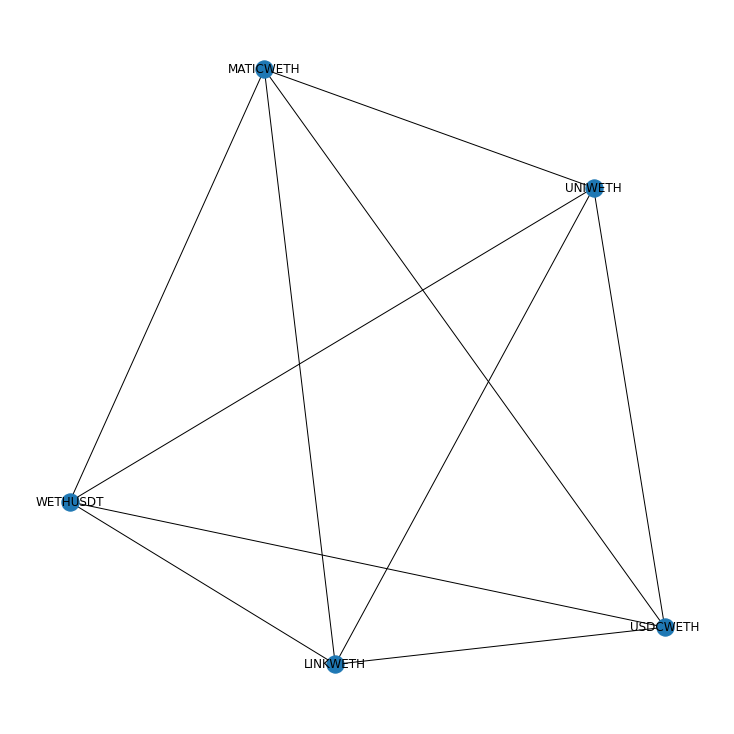

In [156]:
# Lasso clustering
log_returns = np.log1p(univ2_close_price.pct_change())[1:].dropna()

edge_model = covariance.GraphicalLassoCV(cv=40)
log_returns /= log_returns.std(axis=0)
edge_model.fit(log_returns)
p = edge_model.precision_

#prepare the matrix for network illustration
p = pd.DataFrame(p, columns=univ2_close_price.columns, index=univ2_close_price.columns)
links = p.stack().reset_index()
links.columns = ['var1', 'var2','value']
links=links.loc[ (abs(links['value']) > 0.17) &  (links['var1'] != links['var2']) ]
#build the graph using networkx lib
G=nx.from_pandas_edgelist(links,'var1','var2', create_using=nx.Graph())
pos = nx.spring_layout(G, k=0.2*1/np.sqrt(len(G.nodes())), iterations=20)
plt.figure(3, figsize=(10, 10))
nx.draw(G, pos=pos)
nx.draw_networkx_labels(G, pos=pos)
plt.show()